Script to calculate the expected PV performance without weather

Import Packages

In [31]:
import numpy as np              
import matplotlib.pyplot as plt
import datetime
import ephem
import pandas as pd
import matplotlib.dates as mdates

Functions

In [32]:
def calculate_sun_position(latitude, longitude, date):
    # Calculate the sun's position for given coordinates and date
    observer = ephem.Observer()
    observer.lat = str(latitude)
    observer.lon = str(longitude)
    observer.date = date

    sun = ephem.Sun()
    sun.compute(observer)

    azimuth = np.rad2deg(sun.az)
    elevation = np.rad2deg(sun.alt)
    return azimuth, elevation


def calculate_delta_angle(sun_azimut, panel_orientation, sun_elevation, panel_tilt):
    # Calculate the angle between the sun and the solar panel
    # Convert to radians
    sun_azimut = np.deg2rad(sun_azimut)
    panel_orientation = np.deg2rad(panel_orientation)
    sun_elevation = np.deg2rad(sun_elevation)
    panel_tilt = np.deg2rad(panel_tilt)
    # Convert to spherical coordinates, r = 1
    theta_sun = np.pi / 2 - sun_elevation
    theta_panel = np.pi / 2 - panel_tilt
    phi_sun = sun_azimut
    phi_panel = panel_orientation
    # Calculate dot product of the two vectors
    dot_product = np.sin(theta_sun) * np.sin(theta_panel) * np.cos(
        phi_sun - phi_panel
    ) + np.cos(theta_sun) * np.cos(theta_panel)
    # Calculate angle in degrees
    angle = np.rad2deg(np.arccos(dot_product))
    return angle


def create_timestamps(date, time_step):
    # Create an array of timestamps for one day
    start_time = datetime.datetime(date.year, date.month, date.day)
    end_time = start_time + datetime.timedelta(days=1)
    num_steps = int((end_time - start_time) / time_step)
    timestamps = np.array([start_time + i * time_step for i in range(num_steps)])
    return timestamps


def get_sun_trajectory(latitude, longitude, timestamps, timezone):
    # Calculate the sun's position for each timestamp
    sun_azimuths = np.empty(len(timestamps))
    sun_elevations = np.empty(len(timestamps))
    for i, timestamp in enumerate(timestamps):
        timestamp = timestamp - datetime.timedelta(hours=timezone)
        azimuth, elevation = calculate_sun_position(latitude, longitude, timestamp)
        sun_azimuths[i] = azimuth
        sun_elevations[i] = elevation
    return sun_azimuths, sun_elevations


def get_pv_sun_angle(azimuths, elevations, panel_orientation, panel_tilt):
    # Calculate the angle between the sun and the solar panel for each timestep
    angles = np.empty((len(panel_orientation), len(azimuths)))
    for num_panel in range(len(panel_orientation)):
        for i in range(len(azimuths)):
            angles[num_panel, i] = calculate_delta_angle(
                azimuths[i],
                panel_orientation[num_panel],
                elevations[i],
                panel_tilt[num_panel],
            )
    return angles


def calc_irradiance_scaling(elevations):
    # Calculate the irradiance scaling for each elevation
    irradiance = np.zeros(len(elevations))
    for i in range(len(elevations)):
        if elevations[i] > 0:
            irradiance[i] = np.sin(np.deg2rad(elevations[i]))
    return irradiance


def calc_power_ratio(angles, peak_power):
    # Calculate the power ratio for each angle with respect to the peak power
    power_ratio = np.zeros([len(angles), len(angles[0])])
    for panel in range(len(angles)):
        for i in range(len(power_ratio[0])):
            if angles[panel][i] < 90:
                power_ratio[panel][i] += (np.cos(np.deg2rad(angles[panel][i])) 
                                   * peak_power[panel])
    return power_ratio


def create_datainfo_dict_and_dataframe(
    latitude,
    longitude,
    timezone,
    date,
    time_step,
    limit_data,
    timestamps,
    sun_azimuths,
    sun_elevations,
    terrain_mask,
    sun_bool,
    irradiance_scaling,
    power_ratio,
    orientation,
    tilt,
    peak_power,
    angles,
):
    # Create a dict with info and adataframe with the simulation results
    data_info = {
        "latitude": latitude,
        "longitude": longitude,
        "timezone": timezone,
        "date": date.strftime("%d.%m.%Y"),
        "time_step": time_step,
        "limit_data": limit_data,
    }
    df_data = pd.DataFrame(
        {
            "timestamps": timestamps,
            "sun_azimuths": sun_azimuths,
            "sun_elevations": sun_elevations,
            "terrain_mask": terrain_mask,
            "sun_bool": sun_bool,
            "irradiance_scaling": irradiance_scaling,
        }
    )
    for i in range(len(orientation)):
        df_data[f"sun_panel_angle_{i+1}"] = angles[i]
        df_data[f"power_ratio_{i+1}"] = power_ratio[i]
        data_info[f"num_panels"] = len(orientation)
        data_info[f"orientation_{i+1}"] = orientation[i]
        data_info[f"tilt_{i+1}"] = tilt[i]
        data_info[f"peak_power_{i+1}"] = peak_power[i]
    df_data["total_power_ratio"] = df_data.filter(like="power_ratio").sum(axis=1)
    return data_info, df_data


def handle_summertime(date, timezone):
    # Check if the date is in summertime and adjust the timezone
    # Calculate the last Sunday of March at 02:00
    changedate_1 = datetime.datetime(date.year, 3, 31, 2)
    while changedate_1.weekday() != 6:  # Sunday is represented by 6
        changedate_1 -= datetime.timedelta(days=1)

    # Calculate the last Sunday of October at 03:00
    changedate_2 = datetime.datetime(date.year, 10, 31, 3)
    while changedate_2.weekday() != 6:  # Sunday is represented by 6
        changedate_2 -= datetime.timedelta(days=1)
    # Apply the timezone change
    if changedate_1 <= date <= changedate_2:
        timezone += 1
    return timezone


def calculate_terrain_mask(terrain_file, sun_azimuths, sun_elevations):
    # Calculate the terrain mask for each timestep
    terrain_mask = np.zeros(len(sun_azimuths))
    terrain_data = np.genfromtxt(terrain_file, delimiter=',')
    terrain_azimuths = terrain_data[:, 0]
    terrain_elevation = terrain_data[:, 1]
    azimuths_indices = np.empty(len(terrain_azimuths), dtype=np.int32)
    for i, azimuth in enumerate(terrain_azimuths):
        closest_index = np.argmin(np.abs(sun_azimuths - azimuth))
        azimuths_indices[i] = closest_index
        terrain_mask[closest_index] = terrain_elevation[i]
    for i in range(len(terrain_azimuths)):
        startindex = azimuths_indices[i]
        stopindex = azimuths_indices[(i+1)%len(terrain_azimuths)]
        if startindex < stopindex:
            # Interpolate values between startindex and stopindex
            terrain_mask[startindex:stopindex+1] = np.interp(
                np.arange(startindex, stopindex+1),
                [startindex, stopindex],
                [terrain_mask[startindex], terrain_mask[stopindex]]
            )
        else:
            # Get interpolation value for the start and end of the array
            span = len(terrain_mask) - startindex + stopindex
            valuespan = terrain_elevation[0] - terrain_elevation[-1]
            step = valuespan / span
            value_end = terrain_elevation[-1] + step * (len(terrain_mask) - startindex)
            value_begin = value_end + step
            # Interpolate values from startindex to the end of the array
            terrain_mask[startindex:] = np.interp(
                np.arange(startindex, len(terrain_mask)),
                [startindex, len(terrain_mask)-1],
                [terrain_elevation[-1], value_end]
            )
            # Interpolate values from the beginning of the array to stopindex
            terrain_mask[:stopindex+1] = np.interp(
                np.arange(stopindex+1),
                [0, stopindex],
                [value_begin, terrain_elevation[0]]
            )
    sun_bool = np.ones(len(sun_azimuths))
    for i in range(len(sun_bool)):
        if terrain_mask[i] > sun_elevations[i] and sun_elevations[i] > 0:
            sun_bool[i] = 0
            
    return terrain_mask, sun_bool


def limit_to_daylight(df_data):
    # Limit the data to daylight hours
    df_data = df_data[df_data["sun_elevations"] >= 0]
    return df_data


def generate_data(
    date,
    time_step,
    latitude,
    longitude,
    terrain_data,
    timezone,
    auto_summertime,
    orientation,
    tilt,
    peak_power,
    limit_data=True,
):
    timestamps = create_timestamps(date, time_step)
    if auto_summertime:
        timezone = handle_summertime(date, timezone)
    sun_azimuths, sun_elevations = get_sun_trajectory(
        latitude, longitude, timestamps, timezone
    )
    angles = get_pv_sun_angle(sun_azimuths, sun_elevations, orientation, tilt)
    if terrain_data is not None:
        terrain_mask, sun_bool = calculate_terrain_mask(terrain_data, sun_azimuths, sun_elevations)
    else:
        terrain_mask, sun_bool = np.zeros(len(sun_azimuths)), np.ones(len(sun_azimuths))
    irradiance_scaling = calc_irradiance_scaling(sun_elevations)
    power_ratio = calc_power_ratio(angles, peak_power)
    data_info, df_data = create_datainfo_dict_and_dataframe(
        latitude,
        longitude,
        timezone,
        date,
        time_step,
        limit_data,
        timestamps,
        sun_azimuths,
        sun_elevations,
        terrain_mask,
        sun_bool,
        irradiance_scaling,
        power_ratio,
        orientation,
        tilt,
        peak_power,
        angles,
    )
    if limit_data:
        df_data = limit_to_daylight(df_data)
    return data_info, df_data


Plot Functions

In [33]:
def plot_sun_trajectory(data_info, df_data, closest_indices, cardinal_directions):
    # Plot the sun's trajectory
    fig, ax = plt.subplots()
    ax.scatter(
        df_data["timestamps"],
        df_data["sun_elevations"],
        color="orange",
        label="Sun trajectory",
    )
    ax.scatter(df_data["timestamps"], 
            df_data["terrain_mask"], 
            color="black", 
            label="Terrain mask",
    )
    ax.legend()
    ax.set_xlabel("Daytime")
    ax.set_ylabel("Elevation in degrees")
    titletext = (
        "Data for Lat: "
        + str(data_info["latitude"])
        + " and Lon: "
        + str(data_info["longitude"])
        + " on "
        + str(data_info["date"])
        + "\n"
        + "Sun trajectory and terrain mask"
    )
    ax.set_title(titletext)
    ax.grid(True)
    # Format xticklabels to use "%H"
    myFmt = mdates.DateFormatter("%H")
    plt.gca().xaxis.set_major_formatter(myFmt)
    # Add second x-axis with cardinal directions
    ax2 = ax.twiny()
    ax2.set_xlim(-(0.05 * len(df_data)),len(df_data) + (0.05 * len(df_data)))
    ax2.set_xticks(closest_indices)
    ax2.set_xticklabels(cardinal_directions)
    plt.show()


def plot_panel_angles(data_info, df_data, closest_indices, cardinal_directions):
    # Plot the angle between the sun and the solar panel
    fig, ax = plt.subplots()
    for i in range(data_info["num_panels"]):
        ax.scatter(
            df_data["timestamps"],
            df_data[f"sun_panel_angle_{i+1}"],
            label=f"Panel {i+1}",
        )
    ax.set_xlabel("Daytime")
    ax.set_ylabel("Angle in degrees")
    titletext = (
        "Data for Lat: "
        + str(data_info["latitude"])
        + " and Lon: "
        + str(data_info["longitude"])
        + " on "
        + str(data_info["date"])
        + "\n"
        + "Angle between sun and solar panel"
    )
    ax.set_title(titletext)
    ax.grid(True)
    ax.legend()
    # Format xticklabels to use "%H"
    myFmt = mdates.DateFormatter("%H")
    plt.gca().xaxis.set_major_formatter(myFmt)
    # Add second x-axis with cardinal directions
    ax2 = ax.twiny()
    ax2.set_xlim(-(0.05 * len(df_data)),len(df_data) + (0.05 * len(df_data)))
    ax2.set_xticks(closest_indices)
    ax2.set_xticklabels(cardinal_directions)
    plt.show()


def plot_normalized_power(data_info, df_data, closest_indices, cardinal_directions):
    # Plot the self-normalized power output
    fig, ax = plt.subplots()
    for i in range(data_info["num_panels"]):
        ax.scatter(
            df_data["timestamps"],
            df_data[f"power_ratio_{i+1}"] * df_data["irradiance_scaling"] * df_data["sun_bool"] / data_info[f"peak_power_{i+1}"],
            label=f"Panel {i+1}",
        )
    ax.set_xlabel("Daytime")
    ax.set_ylabel("Self-normalized power")
    titletext = (
        "Data for Lat: "
        + str(data_info["latitude"])
        + " and Lon: "
        + str(data_info["longitude"])
        + " on "
        + str(data_info["date"])
        + "\n"
        + "Normalized power output"
    )
    ax.set_title(titletext)
    ax.grid(True)
    ax.legend()
    # Format xticklabels to use "%H"
    myFmt = mdates.DateFormatter("%H")
    plt.gca().xaxis.set_major_formatter(myFmt)
    # Add second x-axis with cardinal directions
    ax2 = ax.twiny()
    ax2.set_xlim(-(0.05 * len(df_data)),len(df_data) + (0.05 * len(df_data)))
    ax2.set_xticks(closest_indices)
    ax2.set_xticklabels(cardinal_directions)
    plt.show()

def plot_expected_power(data_info, df_data, closest_indices, cardinal_directions):
    # Calculate the total expected power output
    seconds_per_step = data_info["time_step"].total_seconds()
    total_raw = np.trapz(df_data["total_power_ratio"] * df_data["irradiance_scaling"])
    total_energy = np.round(
        total_raw * seconds_per_step / 3600 / 1000, 1
    ) # in kWh
    # Plot the expected power output
    fig, ax = plt.subplots()
    for panel in range(data_info["num_panels"]):
        panel_raw = np.trapz(df_data[f"power_ratio_{panel + 1}"] * df_data["irradiance_scaling"])
        panel_energy = np.round(
            panel_raw * seconds_per_step / 3600 / 1000, 1
        ) # in kWh
        ax.scatter(
            df_data["timestamps"],
            df_data["power_ratio_" + str(panel + 1)] * df_data["irradiance_scaling"] * df_data["sun_bool"],
            label="Panel " + str(panel + 1) + ": " + str(panel_energy) + " kWh",
        )
    ax.scatter(
        df_data["timestamps"],
        df_data["total_power_ratio"] * df_data["irradiance_scaling"] * df_data["sun_bool"],
        color="r",
        label="Total: " + str(total_energy) + " kWh",
    )
    ax.set_xlabel("Daytime")
    ax.set_ylabel("Power in Watts")
    ax.legend()
    titletext = (
        "Data for Lat: "
        + str(data_info["latitude"])
        + " and Lon: "
        + str(data_info["longitude"])
        + " on "
        + str(data_info["date"])
        + "\n"
        + "Expected power output"
    )
    ax.set_title(titletext)
    ax.grid(True)
    # Format xticklabels to use "%H"
    myFmt = mdates.DateFormatter("%H")
    plt.gca().xaxis.set_major_formatter(myFmt)
    # Add second x-axis with cardinal directions
    ax2 = ax.twiny()
    ax2.set_xlim(-(0.05 * len(df_data)),len(df_data) + (0.05 * len(df_data)))
    ax2.set_xticks(closest_indices)
    ax2.set_xticklabels(cardinal_directions)
    plt.show()

def plot_select(data_info, df_data, sun, angles, norm_power, power, popout=False):
    if data_info["limit_data"]:
        target_azimuths = []
        cardinal_directions_lookup = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
        cardinal_directions = []
        azimuth_min = df_data["sun_azimuths"].iloc[0] 
        azimuth_max = df_data["sun_azimuths"].iloc[-1]
        for i, angle in enumerate(range(0, 360, 45)):
            if azimuth_min <= angle <= azimuth_max:
                target_azimuths.append(angle)
                cardinal_directions.append(cardinal_directions_lookup[i])
    else:
        target_azimuths = [0, 45, 90, 135, 180, 225, 270, 315]
        cardinal_directions = ["N", "NE", "E", "SE", "S", "SW", "W", "NW"]
    closest_indices = []
    for target in target_azimuths:
        closest_indices.append(np.abs(df_data["sun_azimuths"] - target).argmin())    
    if popout:
        %matplotlib qt
    else:
        %matplotlib inline
    if sun:
        plot_sun_trajectory(data_info, df_data, closest_indices, cardinal_directions)
    if angles:
        plot_panel_angles(data_info, df_data, closest_indices, cardinal_directions)
    if norm_power:
        plot_normalized_power(data_info, df_data, closest_indices, cardinal_directions)
    if power:
        plot_expected_power(data_info, df_data, closest_indices, cardinal_directions)

User input

In [34]:
# Coordinates in degrees
latitude = 48.8 # 48.8
longitude = 9
timezone = 1 # Germany: UTC +1 
auto_summertime = True # Automatically handle summertime for Germany (or similar)

# Panel orientation, tilt and peak power
orientation = np.array([96, 276]) # degrees, north = 0, east = 90, ...
tilt = np.array([30, 44]) # degrees, 0 = horizontal, 90 = vertical
peak_power = np.array([3320, 4980]) # Watts peak

# Terrain elevation data, use None for no data, otherwise provide a path to a .csv file
# terrain_data = "terrain_example_1.csv" # Use "None" if no data is available
terrain_data = None

# Date and stepsize
# Either use specific date or current date + offset, comment unused lines out
date = (datetime.datetime.now() # Current date
        + datetime.timedelta(weeks=0, days=0)) # Add/ substract weeks and days
# date = datetime.datetime.strptime("26.06.2024", "%d.%m.%Y") # Specific date
time_step = datetime.timedelta(minutes=1, seconds=0) # Time steps for simulation

# Limit data to daylight hours
limit_data = True

# Select plots to show and popout option
sun, angles, normpower, power, popout = True, True, True, True, False

Run script

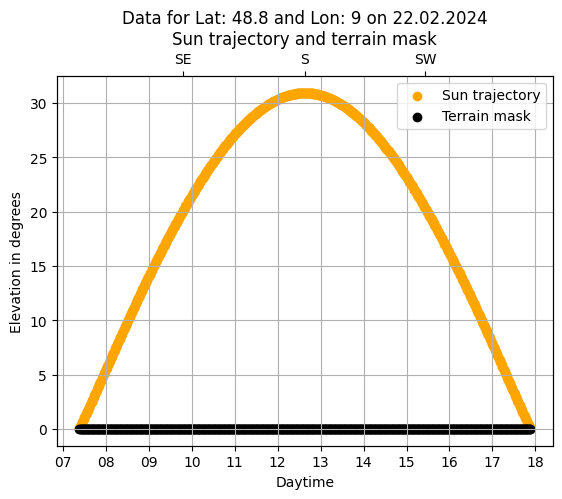

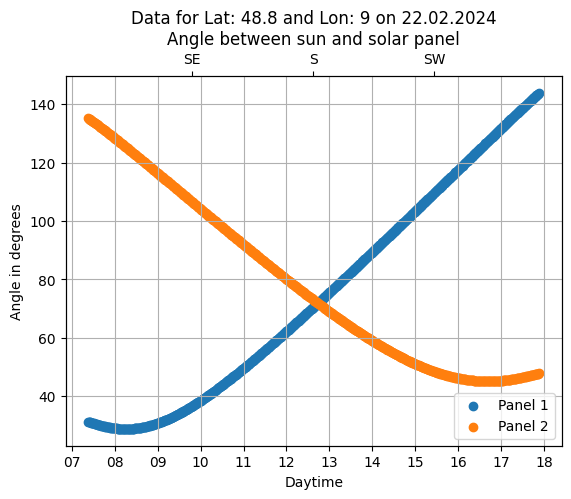

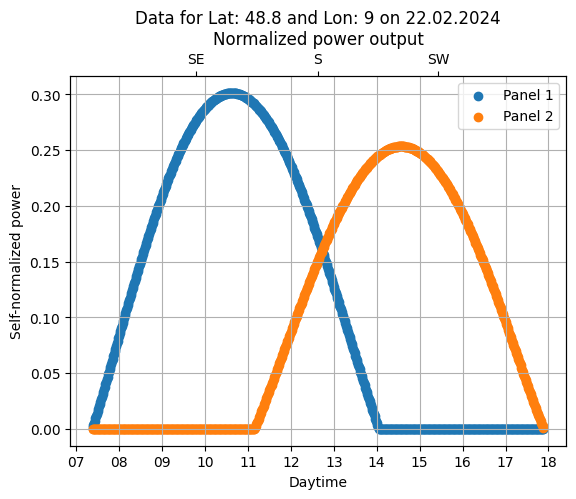

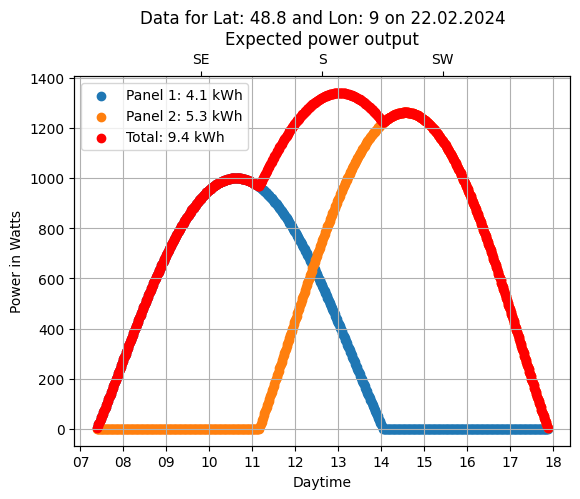

In [35]:
data_info, df_data = generate_data(
    date,
    time_step,
    latitude,
    longitude,
    terrain_data,
    timezone,
    auto_summertime,
    orientation,
    tilt,
    peak_power,
    limit_data,
)

# Plot the results
plot_select(data_info, df_data, sun, angles, normpower, power, popout)